In [105]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import torch
from torch import nn
from transformers import CLIPTextModel, CLIPTokenizer


In [106]:
df = pd.read_csv(f'dataset/pokemon_preprocessed.csv')
types = df[['name','type1']]
prompts = pd.read_csv(f'dataset/pokemon_prompts.csv')
df = pd.merge(left = types, right=prompts, how = 'inner', on='name')

In [107]:
df

,name,type1,prompts
0,Bulbasaur,grass,"['grass-type', 'starter', 'plant-like creature..."
1,Ivysaur,grass,"['leafy', 'bulb', 'evolved form', 'plant-like'..."
2,Venusaur,grass,"['bulbous', 'leafy', 'proud', 'majestic', 'her..."
3,Charmander,fire,"['fire-breathing', 'tail-wagging', 'salamander..."
4,Charmeleon,fire,"['Fire-breathing', 'Scaly', 'Flame-tipped tail..."
...,...,...,...
775,Celesteela,steel,"['Legendary', 'Gigantic', 'Jet-powered', 'Stee..."
776,Kartana,grass,"['Ultra Beast', 'Legendary', 'Steel-type', 'Bl..."
777,Guzzlord,dark,"['gargantuan', 'abyssal', 'ravenous', 'shadowy..."
778,Necrozma,psychic,"['Legendary', 'Mysterious', 'Radiant', 'Alien-..."


(array([127., 186., 130.,  38.,  46.,  79.,  41.,  50.,  56.,  27.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

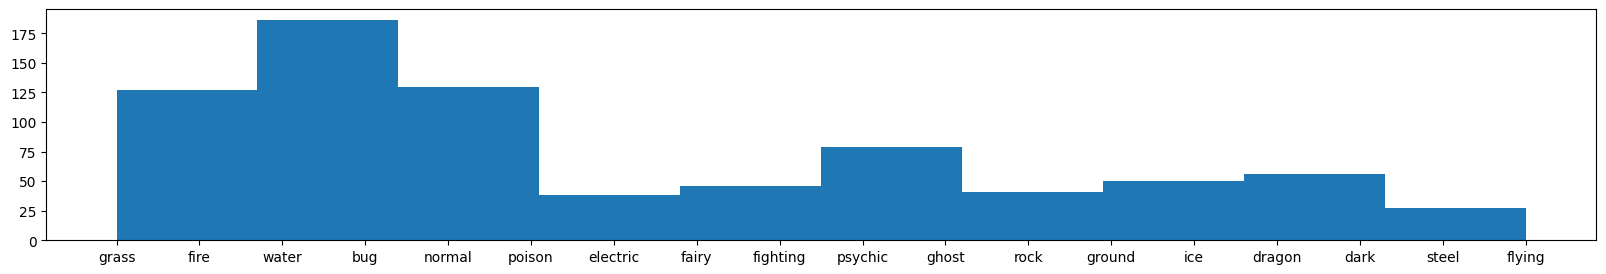

In [108]:
plt.figure(figsize=(20,3))
plt.hist(df['type1'])

In [109]:
tokenizer = CLIPTokenizer.from_pretrained("xyn-ai/anything-v4.0", subfolder="tokenizer", revision=None)
text_encoder = CLIPTextModel.from_pretrained("xyn-ai/anything-v4.0", subfolder="text_encoder", revision=None)

In [110]:
category = df['type1'].unique()
category

array(['grass', 'fire', 'water', 'bug', 'normal', 'poison', 'electric',
       'fairy', 'fighting', 'psychic', 'ghost', 'rock', 'ground', 'ice',
       'dragon', 'dark', 'steel', 'flying'], dtype=object)

In [111]:
input_ids = tokenizer(f'image of fire type pokemon',max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")
attention_mask = input_ids.attention_mask
input_ids = input_ids.input_ids

In [112]:
encoder_hidden_states = text_encoder(input_ids)[0]
attention_mask
encoder_hidden_states.shape

torch.Size([1, 77, 768])

In [113]:
result = encoder_hidden_states* attention_mask.reshape(1,77,1)

In [114]:
result.mean(axis = 1).shape


torch.Size([1, 768])

In [115]:
category_latent_vectors =[]
for c in category:
    template_prompt = f'A photo of {c} pokemon'
    tokenized= tokenizer(template_prompt,max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")
    attention_mask = tokenized.attention_mask
    input_ids = tokenized.input_ids
    encoder_hidden_states = text_encoder(input_ids)[0]
    result = encoder_hidden_states* attention_mask.reshape(1,77,1)
    result = result.mean(axis = 1).reshape(-1)
    category_latent_vectors.append(result)

In [116]:
len(category_latent_vectors)

18

In [117]:
correct = 0
pred = []
for prompt, ptype in zip(df['prompts'],df['type1']):
    input = prompt.replace("'","")[1:-1]
    tokenized= tokenizer(input,max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt")
    attention_mask = tokenized.attention_mask
    input_ids = tokenized.input_ids
    encoder_hidden_states = text_encoder(input_ids)[0]
    result = encoder_hidden_states* attention_mask.reshape(1,77,1)
    result = result.mean(axis = 1).reshape(-1)

    temp = []
    for category_latent_vector in category_latent_vectors:
        temp.append(torch.matmul(result, category_latent_vector).detach().numpy())
    
    pred.append(np.argmax(temp))
    if(category[np.argmax(temp)] == ptype):
        correct += 1
    

In [118]:
correct / len(df)

0.5948717948717949